## Imports:

In [2]:
# #standard modules
# import pandas as pd
# import numpy as np
# import os
# import re
# #plots:
# import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle
# import cartopy
# import cartopy.feature as cf
# import cartopy.crs as ccrs
# import seaborn as sns
# import folium
# from folium.plugins import HeatMap, HeatMapWithTime
# #data
# from netCDF4 import Dataset
# from pandas import datetime
# #IO
# import openpyxl
# #speedup
# from numba import jit
# #animations
# from celluloid import Camera # getting the camera
# from IPython.display import HTML # to show the animation in Jupyter

from functions import plot_merra_data, plot_outcome_data, plot_wind_vectorfield, plot_grid
# from functions import plot_main_dust
import os
import pickle
import numpy as np
import pandas as pd
import os
from netCDF4 import Dataset

import matplotlib.pyplot as plt


from functions import process_merra_data

import statsmodels.api as sm

from numba import jit


In [3]:
parent_directory = os.path.abspath(os.path.join(os.path.dirname(os.path.realpath("__file__")), os.pardir))

# 3. Empirical Strategy

## 3.1 Physical Model

### Data

In [4]:
with open(parent_directory + '\\processed_data\\hourly_novapr_indices', 'rb') as pickle_file:
        hourly_novapr_indices = pickle.load(pickle_file)

with open(parent_directory + '\\processed_data\\hourly_junsep_indices', 'rb') as pickle_file:
        hourly_junsep_indices = pickle.load(pickle_file)

In [5]:
west_africa_longitudes = np.load(parent_directory + '\\processed_data\\west_africa_longitudes.npy')
west_africa_latitudes = np.load(parent_directory + '\\processed_data\\west_africa_latitudes.npy')

In [6]:
wind_eastward_hourly_data = np.load(parent_directory + '\\processed_data\\wind_eastward_hourly_data.npy')
wind_northward_hourly_data = np.load(parent_directory + '\\processed_data\\wind_northward_hourly_data.npy')
wind_eastward_hourly_novapr_data = np.load(parent_directory + '\\processed_data\\wind_eastward_hourly_novapr_data.npy')
wind_northward_hourly_novapr_data = np.load(parent_directory + '\\processed_data\\wind_northward_hourly_novapr_data.npy')
wind_eastward_hourly_junsep_data = np.load(parent_directory + '\\processed_data\\wind_eastward_hourly_junsep_data.npy')
wind_northward_hourly_junsep_data = np.load(parent_directory + '\\processed_data\\wind_northward_hourly_junsep_data.npy')

In [7]:
dust_hourly_data = np.load(parent_directory + '\\processed_data\\dust_hourly_data.npy') 
dust_hourly_novapr_data = np.load(parent_directory + '\\processed_data\\dust_hourly_novapr_data.npy')
dust_hourly_junsep_data = np.load(parent_directory + '\\processed_data\\dust_hourly_junsep_data.npy')

### Plots

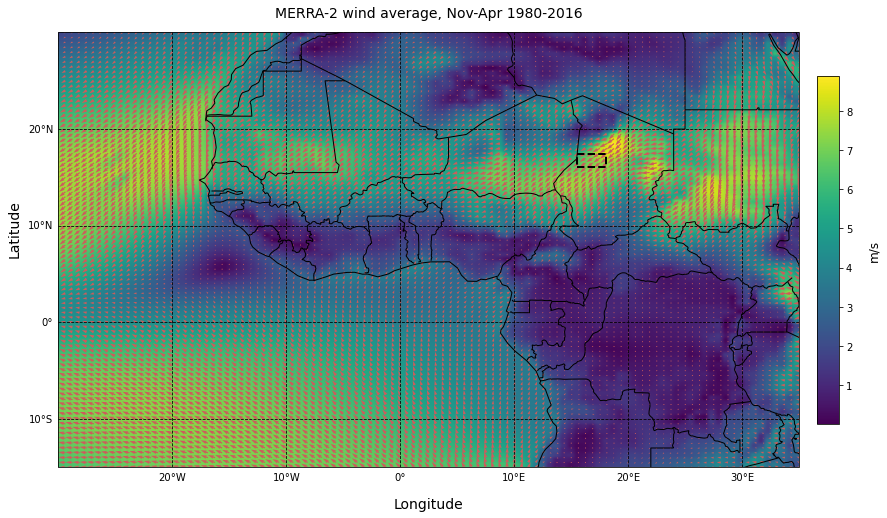

In [8]:
plot_wind_vectorfield(np.sum(wind_eastward_hourly_novapr_data, axis = 0)/wind_eastward_hourly_novapr_data.shape[0],
                      np.sum(wind_northward_hourly_novapr_data, axis = 0)/wind_northward_hourly_novapr_data.shape[0], 
                      west_africa_longitudes, west_africa_latitudes, fig_size = (16,8), title= 'MERRA-2 Mean Wind, ',
                      date='Nov-Apr 1980-2016', data_value='m/s',extent = [-30,35,30,-15], borders = True,
                      bodele = True, interpolation = "hermite")

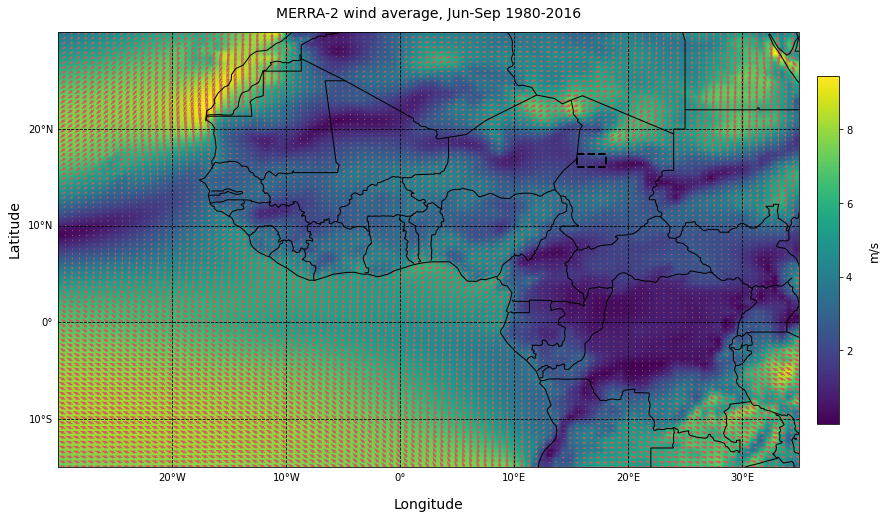

In [9]:
plot_wind_vectorfield(np.sum(wind_eastward_hourly_junsep_data, axis = 0)/wind_eastward_hourly_junsep_data.shape[0],
                      np.sum(wind_northward_hourly_junsep_data, axis = 0)/wind_northward_hourly_junsep_data.shape[0],
                      west_africa_longitudes, west_africa_latitudes, fig_size = (16,8), title= 'MERRA-2 Mean Wind, ',
                      date='Jun-Sep 1980-2016', data_value='m/s',extent = [-30,35,30,-15], borders = True,
                      bodele = True, interpolation = "hermite")

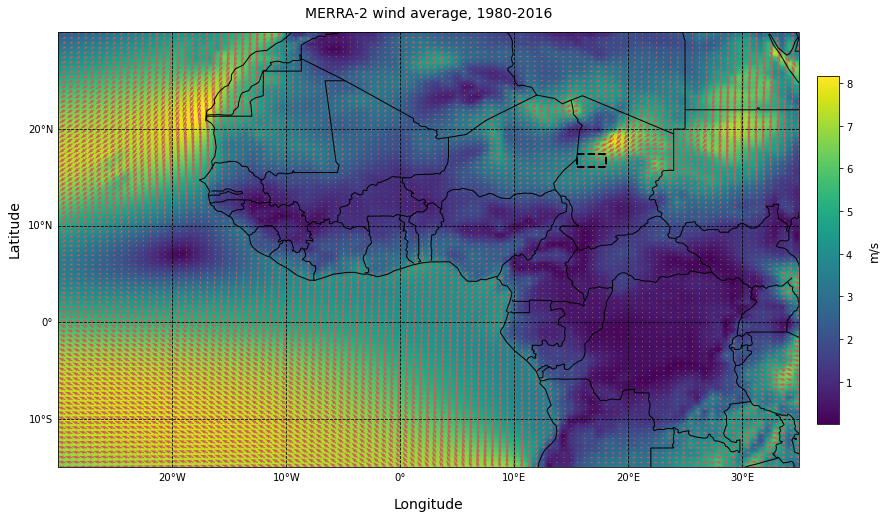

In [10]:
plot_wind_vectorfield(np.sum(wind_eastward_hourly_data, axis = 0)/wind_eastward_hourly_data.shape[0],
                      np.sum(wind_northward_hourly_data, axis = 0)/wind_northward_hourly_data.shape[0],
                      west_africa_longitudes, west_africa_latitudes, fig_size = (16,8),
                      title= 'MERRA-2 Mean Wind, ', date='1980-2016', data_value='m/s', 
                      extent = [-30,35,30,-15], borders = True,
                      bodele = True, interpolation = "hermite")

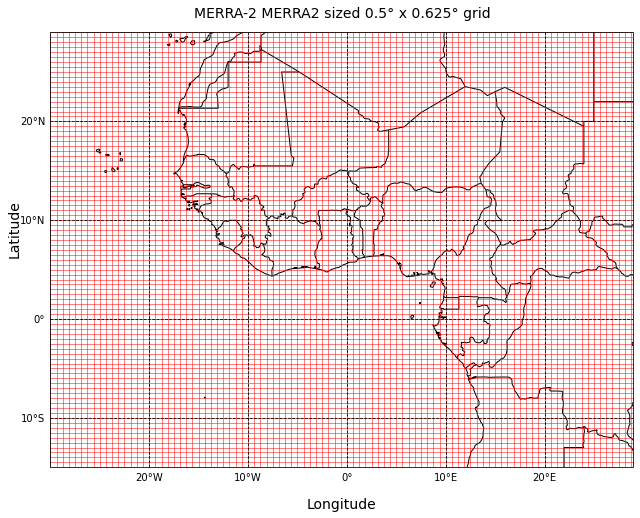

In [11]:
plot_grid(west_africa_latitudes, west_africa_longitudes,
          'MERRA-2 sized 0.5° x 0.625° grid',
          extent=[-30,29,-15,29], borders = True)

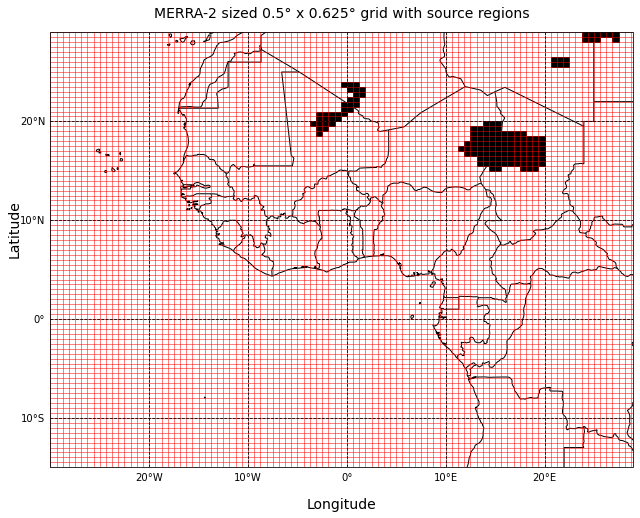

In [12]:
plot_grid(west_africa_latitudes, west_africa_longitudes,
          'MERRA-2 sized 0.5° x 0.625° grid with source regions',
          extent=[-30,29,-15,29], borders = True,
          add_source_region = True)

Equation from paper:
$$\frac{\partial f(x,t)}{\partial t} + U(x,t) \frac{\partial f(x,t)}{\partial x} = D \frac{\partial^{2} f(x,t)}{\partial x^{2}}$$

Discrete equation:

$$\frac{f^{n+1}_{i,j} - f^{n}_{i,j}}{\Delta t} = D \Bigg(\frac{f^{n}_{i+1,j} - 2 f^{n}_{i,j} + f^{n}_{i-1,j}}{\Delta x^{2}} + \frac{f^{n}_{i,j+1} - 2 f^{n}_{i,j} + f^{n}_{i,j-1}}{\Delta y^{2}} \Bigg) - U^{n}_{x,i,j} \frac{f^{n}_{i+1,j} - f^{n}_{i-1,j}}{2 \Delta x} - U^{n}_{y,i,j} \frac{f^{n}_{i,j+1} - f^{n}_{i,j-1}}{2 \Delta y}$$

Transpose: 

$$f^{n+1}_{i,j} = \Delta t * D \Bigg(\frac{f^{n}_{i+1,j} - 2 f^{n}_{i,j} + f^{n}_{i-1,j}}{\Delta x^{2}} + \frac{f^{n}_{i,j+1} - 2 f^{n}_{i,j} + f^{n}_{i,j-1}}{\Delta y^{2}} \Bigg) - U^{n}_{x,i,j} \frac{\Delta t}{2 \Delta x}\Bigg(f^{n}_{i+1,j} - f^{n}_{i-1,j} \Bigg) - U^{n}_{y,i,j} \frac{\Delta t}{2 \Delta y} \Bigg( f^{n}_{i,j+1} - f^{n}_{i,j-1} \Bigg) + f^{n}_{i,j}$$
---
Where: 
$$ f(x,t) = \text{dust distribution} $$
$$ x = \text{position vector} $$
$$ U(x,t) = \text{wind field} $$

$$ D = \text{constant that determines rate of diffusion} $$
$$ f^{n}_{i,j} = \text{dust distribution at time n and position i,j} $$
<!-- $$ f^{n+1}_{i,j} = \text{dust distribution at time n+1 and position i,j} $$ -->
$$ \Delta t = \text{time step} $$
$$ \Delta x = \text{x step in grid} $$
$$ \Delta y = \text{y step in grid} $$
$$ U^{n}_{x,i,j} = \text{wind speed x component at time n and position i,j} $$
$$ U^{n}_{y,i,j} = \text{wind speed y component at time n and position i,j} $$

In [13]:
simulated_dustmass_hourly_data = np.load(parent_directory + '\\processed_data\\simulated_dustmass_hourly_data.npy')
simulated_dustmass_hourly_novapr_data = np.load(parent_directory + '\\processed_data\\simulated_dustmass_hourly_novapr_data.npy')
simulated_dustmass_hourly_junsep_data = np.load(parent_directory + '\\processed_data\\simulated_dustmass_hourly_junsep_data.npy')

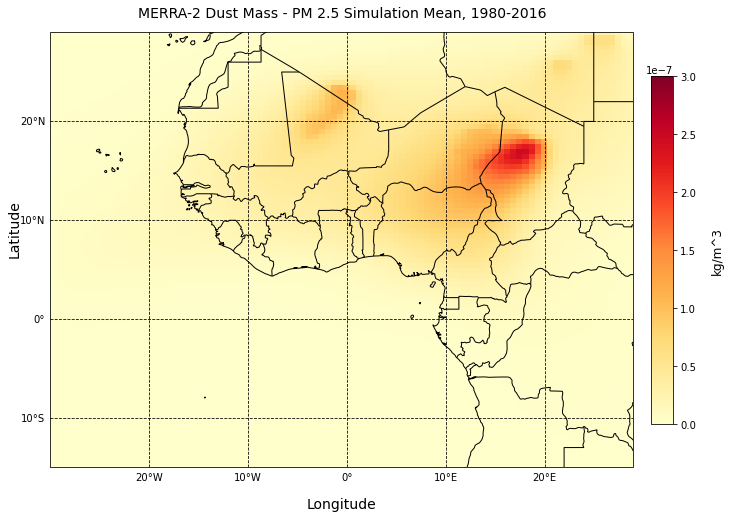

In [14]:
plot_merra_data(np.sum(simulated_dustmass_hourly_data, axis = 0)/simulated_dustmass_hourly_data.shape[0],
                west_africa_longitudes, west_africa_latitudes, title='MERRA-2 Dust Mass - PM 2.5 Simulation Mean, ',
                date='1980-2016', data_value='kg/m^3', extent=[-30,29,-15,29], borders = True,
                bodele = False, plot_grids = True, cbar_max = 3, unit = 10 ** -7)

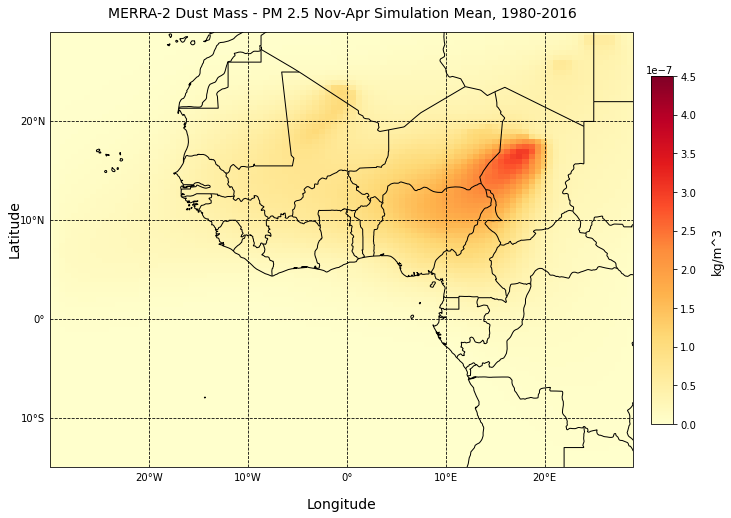

In [15]:
plot_merra_data(np.sum(simulated_dustmass_hourly_novapr_data, axis = 0)/simulated_dustmass_hourly_novapr_data.shape[0],
                west_africa_longitudes, west_africa_latitudes, title='MERRA-2 Dust Mass - PM 2.5 Nov-Apr Simulation Mean, ',
                date='1980-2016', data_value='kg/m^3', extent=[-30,29,-15,29], borders = True,
                bodele = False, plot_grids = True, cbar_max = 4.5, unit = 10 ** -7)

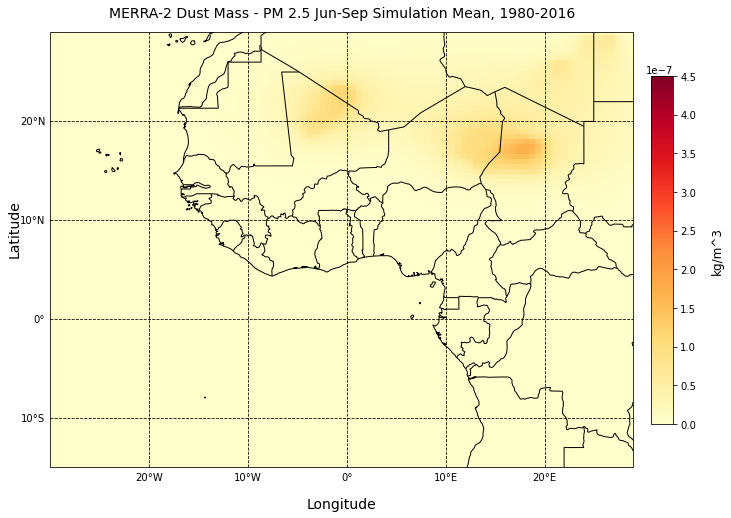

In [16]:
plot_merra_data(np.sum(simulated_dustmass_hourly_junsep_data, axis = 0)/simulated_dustmass_hourly_junsep_data.shape[0],
                west_africa_longitudes, west_africa_latitudes, title='MERRA-2 Dust Mass - PM 2.5 Jun-Sep Simulation Mean, ',
                date='1980-2016', data_value='kg/m^3', extent=[-30,29,-15,29], borders = True,
                bodele = False, plot_grids = True, cbar_max = 4.5, unit = 10 ** -7)